## Digit Recognizer
https://www.kaggle.com/c/digit-recognizer

In [1]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt
print(cv2.__version__)

4.11.0


## Загружаем исходные данные

In [2]:
from keras.datasets import mnist

(train_X, train_y), (test_X, test_y) = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
# посмотрим на размерность
train_X.shape, train_y.shape, test_X.shape, test_y.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [4]:
# приводим размерность к удобному для обаботки виду
train_img = np.resize(train_X[:, 1:], (train_X.shape[0], 28, 28)).astype('float64')
test_img = np.resize(test_X, (test_X.shape[0], 28, 28)).astype('float64')

In [5]:
train_img.shape

(60000, 28, 28)

## Визуализируем исходные данные

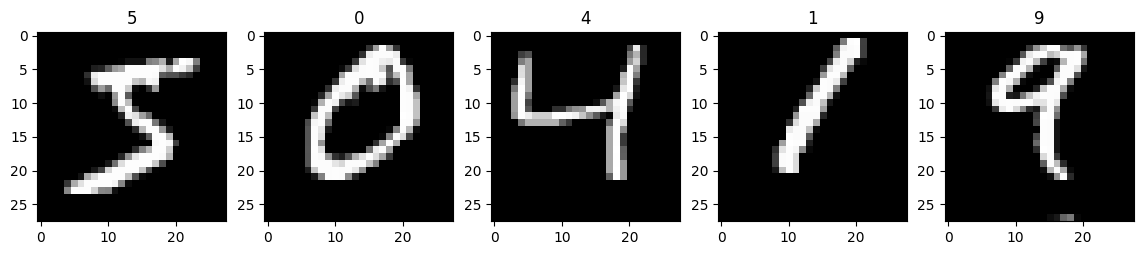

In [6]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_y[i - 1]);

## Вычисляем X и Y составляющие градиента с помощью оператора Собеля

In [50]:
# зададим размер окна
ksize = 7

In [51]:
train_sobel_x = np.zeros_like(train_img)
train_sobel_y = np.zeros_like(train_img)
for i in range(len(train_img)):
    train_sobel_x[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=1, dy=0, ksize=ksize)
    train_sobel_y[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=0, dy=1, ksize=ksize)

In [52]:
test_sobel_x = np.zeros_like(test_img)
test_sobel_y = np.zeros_like(test_img)
for i in range(len(test_img)):
    test_sobel_x[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=1, dy=0, ksize=ksize)
    test_sobel_y[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=0, dy=1, ksize=ksize)

## Вычисляем угол и длину вектора градиента

In [53]:
train_g, train_theta = cv2.cartToPolar(train_sobel_x, train_sobel_y)

In [54]:
test_g, test_theta = cv2.cartToPolar(test_sobel_x, test_sobel_y)

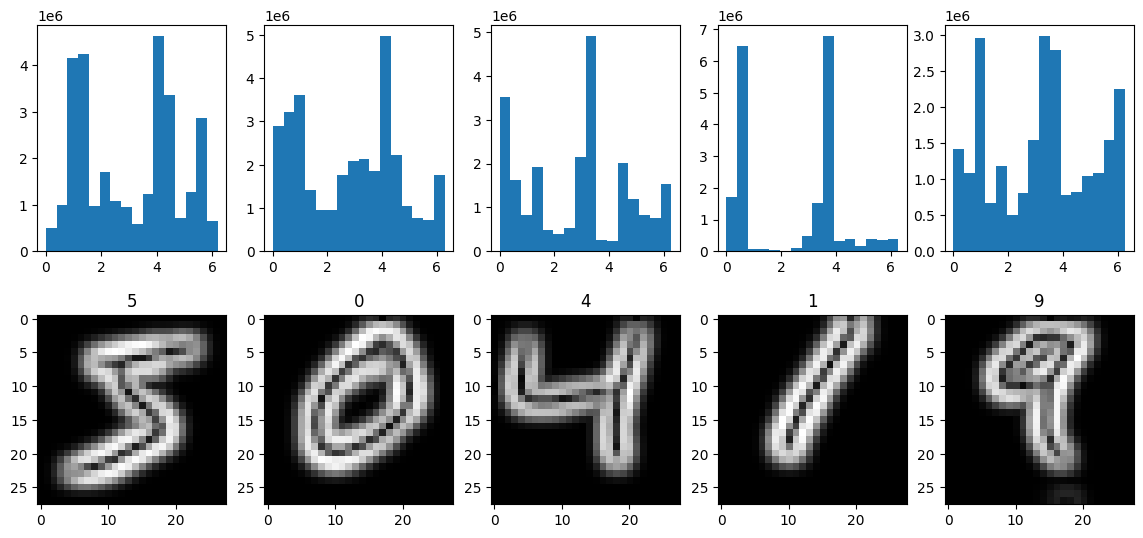

In [73]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_g[:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_y[i - 1]);
    subplot = fig.add_subplot(3, 7, i)
    plt.hist(train_theta[i - 1].flatten(),
             bins=16, weights=train_g[i - 1].flatten())

## Вычисляем гистограммы градиентов

In [56]:
# Гистограммы вычисляются с учетом длины вектора градиента
train_hist = np.zeros((len(train_img), 16))
for i in range(len(train_img)):
    hist, borders = np.histogram(train_theta[i],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=train_g[i])
    train_hist[i] = hist

In [57]:
test_hist = np.zeros((len(test_img), 16))
for i in range(len(test_img)):
    hist, borders = np.histogram(test_theta[i],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=test_g[i])
    test_hist[i] = hist

## Нормируем вектор гистограммы

In [58]:
# По умолчанию используется L2 норма
train_hist = train_hist / np.linalg.norm(train_hist, axis=1)[:, None]

In [97]:
train_hist[100]

array([0.33696449, 0.12871648, 0.01924945, 0.0207989 , 0.00362289,
       0.027586  , 0.06332381, 0.67268247, 0.14070088, 0.22270517,
       0.0219971 , 0.03082685, 0.01736839, 0.02814705, 0.02081288,
       0.58261698])

In [59]:
test_hist = test_hist / np.linalg.norm(test_hist, axis=1)[:, None]

## Разбиваем выборку на обучение и валидацию

In [60]:
from sklearn.model_selection import train_test_split
y_train, y_val, x_train, x_val = train_test_split(train_y, train_hist,
                                                  test_size=0.2,
                                                  random_state=42)

In [93]:
x_train

array([[0.14280526, 0.57228573, 0.2287953 , ..., 0.05567102, 0.05975184,
        0.11116342],
       [0.20647909, 0.18755545, 0.4182331 , ..., 0.31197988, 0.10901316,
        0.0966558 ],
       [0.1785974 , 0.18278347, 0.27664512, ..., 0.27415956, 0.18395475,
        0.1647041 ],
       ...,
       [0.64863108, 0.42817907, 0.02224073, ..., 0.02489415, 0.03328955,
        0.0459215 ],
       [0.14573971, 0.14621083, 0.3444343 , ..., 0.13659173, 0.09981175,
        0.09362439],
       [0.28231263, 0.20458825, 0.26355903, ..., 0.11586139, 0.10501425,
        0.13372965]])

## Вычисляем центроиды каждого из 10 классов

In [85]:
centroids = np.zeros((10, train_hist.shape[1]), dtype=np.float32)

In [75]:
for i in range(10):
    centroids[i] = np.mean(x_train[y_train == i], axis=0)

In [89]:
centroids = np.mean(x_train, axis=0)

In [91]:
centroids.shape

(16,)

In [92]:
centroids

array([0.34953743, 0.28176752, 0.19925274, 0.20509481, 0.15741461,
       0.117896  , 0.12914686, 0.18719495, 0.36625266, 0.26779394,
       0.18164388, 0.20553527, 0.17008326, 0.12933097, 0.12970268,
       0.17465635])

## Находим ближайший центройд для валидации

In [87]:
from sklearn.neighbors import NearestCentroid

In [90]:
model = NearestCentroid()

# Training the classifier
model.fit(centroids, y_train)

# Printing Accuracy on Training and Test sets
print(f"Training Set Score : {model.score(x_train, y_train) * 100} %")
print(f"Test Set Score : {model.score(x_test, y_test) * 100} %")

# Printing classification report of classifier on the test set set data
print(f"Model Classification Report : \n{classification_report(y_test, model.predict(X_test))}")

ValueError: Expected 2D array, got 1D array instead:
array=[0.34953743 0.28176752 0.19925274 0.20509481 0.15741461 0.117896
 0.12914686 0.18719495 0.36625266 0.26779394 0.18164388 0.20553527
 0.17008326 0.12933097 0.12970268 0.17465635].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [76]:
pred_val = np.zeros_like(y_val)
for i in range(len(y_val)):
    distances = np.linalg.norm(centroids - x_val[i], axis=1)
    pred_val[i] = np.argmin(distances)

## Оцениваем качество решение на валидационной выборке

In [77]:
from sklearn.metrics import accuracy_score
print('Accuracy: %s' % accuracy_score(y_val, pred_val))

Accuracy: 0.10166666666666667


In [78]:
from sklearn.metrics import classification_report
print(classification_report(y_val, pred_val))

              precision    recall  f1-score   support

           0       0.11      0.03      0.04      1175
           1       0.12      0.23      0.16      1322
           2       0.10      0.03      0.05      1174
           3       0.11      0.07      0.09      1219
           4       0.10      0.29      0.14      1176
           5       0.09      0.15      0.11      1104
           6       0.09      0.09      0.09      1177
           7       0.10      0.07      0.08      1299
           8       0.11      0.03      0.05      1160
           9       0.10      0.01      0.02      1194

    accuracy                           0.10     12000
   macro avg       0.10      0.10      0.08     12000
weighted avg       0.10      0.10      0.08     12000



In [79]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_val, pred_val))

[[ 30 244  46  75 354 174 124  87  32   9]
 [ 28 308  56  91 358 205 116 112  34  14]
 [ 27 234  40  66 366 186 114  96  35  10]
 [ 27 245  37  85 344 209 121 101  37  13]
 [ 32 253  39  69 341 191 110  85  39  17]
 [ 22 257  42  63 315 167 104  88  32  14]
 [ 38 225  40  95 336 193 104  90  38  18]
 [ 21 281  31  88 398 200 131  93  42  14]
 [ 21 237  44  70 376 179 103  79  39  12]
 [ 25 264  40  64 356 198 113  84  37  13]]


## Предсказания на тестовыйх данных

In [80]:
pred_test = np.zeros(len(test_img), np.uint8)
for i in range(len(test_img)):
    distances = np.linalg.norm(centroids - test_hist[i], axis=1)
    pred_test[i] = np.argmin(distances)

## Визуализируем предсказания

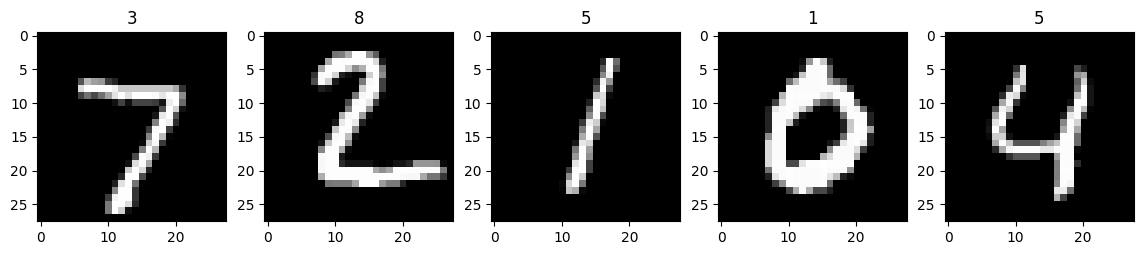

In [81]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(test_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % pred_test[i - 1]);

## Готовим файл для отправки

In [82]:
with open('submit.txt', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(pred_test, 1):
        dst.write('%s,%s\n' % (i, p))

In [83]:
!head submit.txt

ImageId,Label
1,3
2,8
3,5
4,1
5,5
6,5
7,1
8,6
9,4


In [84]:
# Your submission scored 0.41700